## An introduction to Species Distribution Models in Python

*Predicting spatial distributions for ecological species leveraging Python's ever-strengthening machine learning stack.*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** | November 2020

---

***Species Distributions Models (SDMs)*** are an important and widely used tool for ecologists, agriculture scientists, conservation biologists, and many other geospatial science enthusiasts. While dozens of R tutorials leverage the traditional R SDM stack, with packages such as Raster and dismo, (e.g. Robert J. Hijmans and Jane Elith's comprehensive "Species distribution modeling with R"), tutorials with an implementation of SDMs in Python, ***surprisingly***, are limited. To bridge this gap, we will begin to explore a SDM workflow ***powered by Python***, a programming language with far superior machine learning capabilities compared with R. The methods we employ just barely scratch the surface of available techniques, and hopefully this introduction can serve as a springboard to further exploration. 

If you are completely new to SDMs, it may be prudent to start <a target="_blank" rel="noopener noreferrer" href="https://www.google.com/search?q=species+distribution+modeling&oq=species+distribution+modeling&aqs=chrome..69i57j35i39j0l3j69i61l2j69i60.6284j0j1&sourceid=chrome&ie=UTF-8">here</a>. SDMs associate presence locations of a species to climate variables, giving you the power to predict species suitability across an entire landscape. First, environmental variables are sampled from presence coordinates. Second, a statistical model (here, SK-Learn classifiers) defines a species-environment relationship. Third, the species–environment relationship can be mapped across the study space, denoting a potential distribution of the species (referred to as interpolation).  Projecting to future/past climates or to novel geographic areas is referred to as extrapolation. A typical workflow is as follows:

`conceptualization` -> `data pre-processing` -> `model training/assessment` -> 
`interpolate/extrapolate` -> `iterate`

### Tutorial Objectives
---

1. Create a SDM workspace with a Python codebase.
2. Run a suite of SDMs with your ML classifiers of choice.  
3. Visualize model predictions for current climates.

### Section 1 | Set up
---

### Section 1.1 | Workspace

The first step is to create `inputs`/`outputs` folders in our working file directory. It is best practices to keep the data and results separated, as `outputs` folder should be completely reproducible.

In [1]:
import os 
os.mkdir("inputs")
os.mkdir("outputs")

We now install the additional dependencies we will need for our SDMs, with four primary libraries:

* ***scikit-learn***: De-facto Python machine learning
* ***pyimpute***: spatial classification
* ***rasterio***: reads and writes geospatial rasters
* ***geopandas***: spatial operations in Python made easy

These can be installed at the terminal using `pip install LIBRARY`, but you may find it cleaner to create a conda virtual environment from `requirements-py.txt` (see requirement-instructions).

### Section 1.2 | Data Processing

We first need to download a geospatial shapefile (`.shp`) of presence/absence coordinates, which can be directly loaded into Python as a GeoPandas `GeoDataFrame` (a tabular data structure for geometric data types). Here, the `CLASS` column is a binary indication of the presence/absence of the species. For this tutorial, we are using Joshua trees (*Yucca brevifolia*) as the example. To follow along by re-running the chunks, first, clone the **<a target="_blank" rel="noopener noreferrer" href="https://github.com/daniel-furman/py-sdms-tutorial">*Git repo*</a>** and open `Intro-to-SDMs-Py.ipynb` in a working directory of choice.

In [2]:
import geopandas as gpd
import shutil
import glob

# grab jtree data after cloning Git repo
for f in sorted(glob.glob('data/jtree*')):
    shutil.copy(f,'inputs/')
# or grab your data of choice and move to 'inputs/'
pa = gpd.GeoDataFrame.from_file("inputs/jtree.shp")
pa.head(3) # GeoDataFrame for the species

,CLASS,lon,lat,geometry
0,1.0,-116.298937,33.998333,POINT (-116.29894 33.99833)
1,1.0,-116.469370,34.275108,POINT (-116.46937 34.27511)
2,1.0,-113.074417,34.238183,POINT (-113.07442 34.23818)


We now check that there are no duplicate or `NaN` coordinates, as well as inspect the shapefile's attributes.

In [3]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
7200 observations with 4 columns


We can map the species presences (`pa==1`).

<AxesSubplot:>

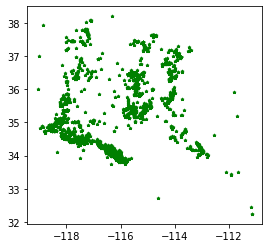

In [7]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=8)

And we can map the background points (`pa == 0`).

<AxesSubplot:>

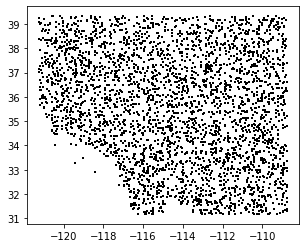

In [8]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=4)

However, if you don't have a geospatial database with presences/absence coordinates, there are some easy steps to create one for ***virtually any species*** of interest! You can start by searching the open-data Global Biodiversity Information Facility (<a target="_blank" rel="noopener noreferrer" href="https://www.gbif.org">GBIF</a>), downloading to `.csv`, and migrate to R to pipe the database to `.shp` (see `data-pre-processing.R`) in the <a target="_blank" rel="noopener noreferrer" href="https://github.com/daniel-furman/py-sdms-tutorial">Git repo</a>. 

### Section 2 | Mapping species suitability
---

In this section we will train our machine learning classifiers and make spatial predictions of the species distribution over current conditions (1970-2000). 

First, we load 19 bioclimatic features (here we use 2.5 arc-minute resolution) from the publicly available [WorldClim database](https://www.worldclim.org) (v. 2.1, Fick & Hijmans, 2017).

In [9]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/bioclim/bclim*.asc')):
    shutil.copy(f,'inputs/')
raster_features = sorted(glob.glob(
    'inputs/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 19 raster features.


We are now ready to use `pyimpute` to generate the raster maps of suitability. We first prep the pyimpute workflow:

In [86]:
from pyimpute import load_training_vector
from pyimpute import load_targets

train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')
target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

((7200, 19), (7200,))

and we implemement several `scikit-learn` classifiers:

In [90]:
# import machine learning classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import model_selection
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier())
    }

from pyimpute import impute
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('outputs/' + name + '-images')
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 93.67 (+/- 0.78)
et 5-fold Cross Validation Accuracy: 93.61 (+/- 1.03)
xgb 5-fold Cross Validation Accuracy: 93.54 (+/- 0.99)
lgbm 5-fold Cross Validation Accuracy: 93.67 (+/- 0.88)


All done! We have a `responses.tif` raster which is the predicted class (0 or 1) and `probability_1.tif` with a continuous suitability scale. Let's average the continuous output for the four models and plot our map.

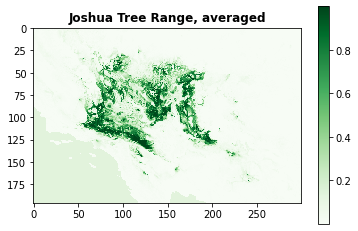

In [92]:
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

import rasterio
distr_rf = rasterio.open("outputs/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Joshua Tree Range, averaged", cmap="Greens")

Lastly, let's zoom in to Joshua Tree National Park and inspect the suitability there.

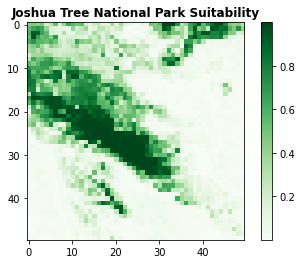

In [93]:
plotit(distr_averaged[100:150, 100:150], "Joshua Tree National Park Suitability", cmap="Greens")

### Additional resources
---
1. <a target="_blank" rel="noopener noreferrer" href="https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf">Species distribution modeling with R</a> (Hijmans and Elith, 2017)
2. Pyimpute's <a target="_blank" rel="noopener noreferrer" href="https://github.com/perrygeo/pyimpute/blob/master/README.md">README.md</a>
3. A study <a target="_blank" rel="noopener noreferrer" href="https://www.researchgate.net/publication/229149956_Selecting_Pseudo-Absences_for_Species_Distribution_Models_How_Where_and_How_Many">on generating pseudo absence points</a>  (Barbet-Massin et al., 2012)
4. A study <a target="_blank" rel="noopener noreferrer" href="https://www.nature.com/articles/s41598-018-25437-1
">on SDM transferability and pixel size</a>  (Manzoor et al., 2018)
5.  A study <a target="_blank" rel="noopener noreferrer" href="https://onlinelibrary.wiley.com/doi/full/10.1111/ddi.13161">on SDMs for invasive species</a>  (Lake et al., 2020)
6. A book <a target="_blank" rel="noopener noreferrer" href="https://www.amazon.com/Mapping-Species-Distributions-Biodiversity-Conservation/dp/0521700027
">on mapping SDMs </a>  (Franklin, 2009)
7. A more modern <a target="_blank" rel="noopener noreferrer" href="https://damariszurell.github.io/SDM-Intro/"> SDMs tutorial </a> (Zurell, 2020) 





### Data Citations
---

1. GBIF.org (01 November 2020) GBIF Occurrence' Download https://doi.org/10.15468/dl.g6swrm 
2. Fick, S.E. and R.J. Hijmans, 2017. WorldClim 2: new 1km spatial resolution climate surfaces for global land areas. International Journal of Climatology 37 (12): 4302-4315.